This IPython Notebook introduces the use of the `openmc.mgxs` module to calculate multi-group cross sections for an infinite homogeneous medium. In particular, this Notebook introduces the the following features:

* **General equations** for scalar-flux averaged multi-group cross sections
* Creation of multi-group cross sections for an **infinite homogeneous medium**
* Use of **tally arithmetic** to manipulate multi-group cross sections

## Introduction to Multi-Group Cross Sections (MGXS)

Many Monte Carlo particle transport codes, including OpenMC, use continuous-energy nuclear cross section data. However, most deterministic neutron transport codes use *multi-group cross sections* defined over discretized energy bins or *energy groups*. An example of U-235's continuous-energy fission cross section along with a 16-group cross section computed for a light water reactor spectrum is displayed below.

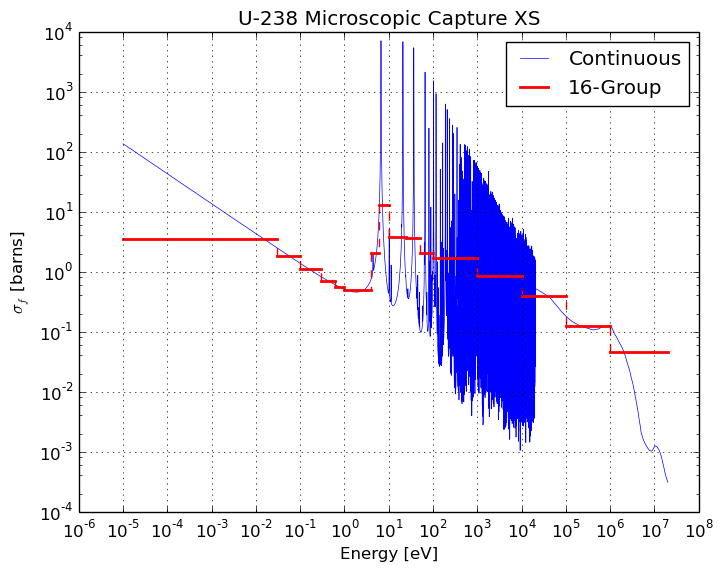

In [1]:
from IPython.display import Image
Image(filename='images/mgxs.png', width=350)

A variety of tools employing different methodologies have been developed over the years to compute multi-group cross sections for certain applications, including NJOY (LANL), MC$^2$-3 (ANL), and Serpent (VTT). The `openmc.mgxs` Python module is designed to leverage OpenMC's tally system to calculate multi-group cross sections with arbitrary energy discretizations for fine-mesh heterogeneous deterministic neutron transport applications.

Before proceeding to illustrate how one may use the `openmc.mgxs` module, it is worthwhile to define the general equations used to calculate multi-group cross sections. This is only intended as a brief overview of the methodology used by `openmc.mgxs` - we refer the interested reader to the large body of literature on the subject for a more comprehensive understanding of this complex topic.

### Introductory Notation
The continuous real-valued microscopic cross section may be denoted $\sigma_{n,x}(\mathbf{r}, E)$ for position vector $\mathbf{r}$, energy $E$, nuclide $n$ and interaction type $x$. Similarly, the scalar neutron flux may be denoted by $\Phi(\mathbf{r},E)$ for position $\mathbf{r}$ and energy $E$. **Note**: Although nuclear cross sections are dependent on the temperature $T$ of the interacting medium, the temperature variable is neglected here for brevity.

### Spatial and Energy Discretization
The energy domain for critical systems such as thermal reactors spans more than 10 orders of magnitude of neutron energies from 10$^{-5}$ - 10$^7$ eV. The multi-group approximation discretization divides this energy range into one or more energy groups. In particular, for $G$ total groups, we denote an energy group index $g$ such that $g \in \{1, 2, ..., G\}$. The energy group indices are defined such that the smaller group the higher the energy, and vice versa. The integration over neutron energies across a discrete energy group is commonly referred to as **energy condensation**.

Multi-group cross sections are computed for discretized spatial zones in the geometry of interest. The spatial zones may be defined on a structured and regular fuel assembly or pin cell mesh, an arbitrary unstructured mesh or the constructive solid geometry used by OpenMC. For a geometry with $K$ distinct spatial zones, we designate each spatial zone an index $k$ such that $k \in \{1, 2, ..., K\}$. The volume of each spatial zone is denoted by $V_{k}$. The integration over discrete spatial zones is commonly referred to as **spatial homogenization**.

### General Scalar-Flux Weighted MGXS
The multi-group cross sections computed by `openmc.mgxs` are defined as a *scalar flux-weighted average* of the microscopic cross sections across each discrete energy group. This formulation is employed in order to preserve the reaction rates within each energy group and spatial zone. In particular, spatial homogenization and energy condensation are used to compute the general multi-group cross section $\sigma_{n,x,k,g}$ as follows:

$$\sigma_{n,x,k,g} = \frac{\int_{E_{g}}^{E_{g-1}}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\sigma_{n,x}(\mathbf{r},E')\Phi(\mathbf{r},E')}{\int_{E_{g}}^{E_{g-1}}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\Phi(\mathbf{r},E')}$$

This scalar flux-weighted average microscopic cross section is computed by `openmc.mgxs` for most multi-group cross sections, including total, absorption, and fission reaction types. These double integrals are stochastically computed with OpenMC's tally system - in particular, [filters](http://openmc.readthedocs.io/en/latest/usersguide/tallies.html#filters) on the energy range and spatial zone (material, cell or universe) define the bounds of integration for both numerator and denominator.

### Multi-Group Scattering Matrices
The general multi-group cross section $\sigma_{n,x,k,g}$ is a vector of $G$ values for each energy group $g$. The equation presented above only discretizes the energy of the incoming neutron and neglects the outgoing energy of the neutron (if any). Hence, this formulation must be extended to account for the outgoing energy of neutrons in the discretized scattering matrix cross section used by deterministic neutron transport codes. 

We denote the incoming and outgoing neutron energy groups as $g$ and $g'$ for the microscopic scattering matrix cross section $\sigma_{n,s}(\mathbf{r},E)$. As before, spatial homogenization and energy condensation are used to find the multi-group scattering matrix cross section $\sigma_{n,s,k,g \to g'}$ as follows:

$$\sigma_{n,s,k,g\rightarrow g'} = \frac{\int_{E_{g'}}^{E_{g'-1}}\mathrm{d}E''\int_{E_{g}}^{E_{g-1}}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\sigma_{n,s}(\mathbf{r},E'\rightarrow E'')\Phi(\mathbf{r},E')}{\int_{E_{g}}^{E_{g-1}}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\Phi(\mathbf{r},E')}$$

This scalar flux-weighted multi-group microscopic scattering matrix is computed using OpenMC tallies with both energy in and energy out filters.

### Multi-Group Fission Spectrum
The energy spectrum of neutrons emitted from fission is denoted by $\chi_{n}(\mathbf{r},E' \rightarrow E'')$ for incoming and outgoing energies $E'$ and $E''$, respectively. Unlike the multi-group cross sections $\sigma_{n,x,k,g}$ considered up to this point, the fission spectrum is a probability distribution and must sum to unity. The outgoing energy is typically much less dependent on the incoming energy for fission than for scattering interactions. As a result, it is common practice to integrate over the incoming neutron energy when computing the multi-group fission spectrum. The fission spectrum may be simplified as $\chi_{n}(\mathbf{r},E)$ with outgoing energy $E$.

Unlike the multi-group cross sections defined up to this point, the multi-group fission spectrum is weighted by the fission production rate rather than the scalar flux. This formulation is intended to preserve the total fission production rate in the multi-group deterministic calculation. In order to mathematically define the multi-group fission spectrum, we denote the microscopic fission cross section as $\sigma_{n,f}(\mathbf{r},E)$ and the average number of neutrons emitted from fission interactions with nuclide $n$ as $\nu_{n}(\mathbf{r},E)$. The multi-group fission spectrum $\chi_{n,k,g}$ is then the probability of fission neutrons emitted into energy group $g$. 

Similar to before, spatial homogenization and energy condensation are used to find the multi-group fission spectrum $\chi_{n,k,g}$ as follows:

$$\chi_{n,k,g'} = \frac{\int_{E_{g'}}^{E_{g'-1}}\mathrm{d}E''\int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\chi_{n}(\mathbf{r},E'\rightarrow E'')\nu_{n}(\mathbf{r},E')\sigma_{n,f}(\mathbf{r},E')\Phi(\mathbf{r},E')}{\int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\nu_{n}(\mathbf{r},E')\sigma_{n,f}(\mathbf{r},E')\Phi(\mathbf{r},E')}$$

The fission production-weighted multi-group fission spectrum is computed using OpenMC tallies with both energy in and energy out filters.

This concludes our brief overview on the methodology to compute multi-group cross sections. The following sections detail more concretely how users may employ the `openmc.mgxs` module to power simulation workflows requiring multi-group cross sections for downstream deterministic calculations.

## Generate Input Files

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import openmc
import openmc.mgxs as mgxs

We being by creating a material for the homogeneous medium.

In [3]:
# Instantiate a Material and register the Nuclides
inf_medium = openmc.Material(name='moderator')
inf_medium.set_density('g/cc', 5.)
inf_medium.add_nuclide('H1',  0.028999667)
inf_medium.add_nuclide('O16', 0.01450188)
inf_medium.add_nuclide('U235', 0.000114142)
inf_medium.add_nuclide('U238', 0.006886019)
inf_medium.add_nuclide('Zr90', 0.002116053)

With our material, we can now create a `Materials` object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials collection and export to XML
materials_file = openmc.Materials([inf_medium])
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a simple square cell with reflective boundary conditions to simulate an infinite homogeneous medium. The first step is to create the outer bounding surfaces of the problem.

In [5]:
# Instantiate boundary Planes
min_x = openmc.XPlane(boundary_type='reflective', x0=-0.63)
max_x = openmc.XPlane(boundary_type='reflective', x0=0.63)
min_y = openmc.YPlane(boundary_type='reflective', y0=-0.63)
max_y = openmc.YPlane(boundary_type='reflective', y0=0.63)

With the surfaces defined, we can now create a cell that is defined by intersections of half-spaces created by the surfaces.

In [6]:
# Instantiate a Cell
cell = openmc.Cell(cell_id=1, name='cell')

# Register bounding Surfaces with the Cell
cell.region = +min_x & -max_x & +min_y & -max_y

# Fill the Cell with the Material
cell.fill = inf_medium

OpenMC requires that there is a "root" universe. Let us create a root universe and add our square cell to it.

In [7]:
# Create root universe
root_universe = openmc.Universe(name='root universe', cells=[cell])

We now must create a geometry that is assigned a root universe and export it to XML.

In [8]:
# Create Geometry and set root Universe
openmc_geometry = openmc.Geometry(root_universe)

# Export to "geometry.xml"
openmc_geometry.export_to_xml()

Next, we must define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 2500 particles.

In [9]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 2500

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Now we are ready to generate multi-group cross sections! First, let's define a 2-group structure using the built-in `EnergyGroups` class.

In [10]:
# Instantiate a 2-group EnergyGroups object
groups = mgxs.EnergyGroups()
groups.group_edges = np.array([0., 0.625, 20.0e6])

We can now use the `EnergyGroups` object, along with our previously created materials and geometry, to instantiate some `MGXS` objects from the `openmc.mgxs` module. In particular, the following are subclasses of the generic and abstract `MGXS` class:

* `TotalXS`
* `TransportXS`
* `AbsorptionXS`
* `CaptureXS`
* `FissionXS`
* `KappaFissionXS`
* `ScatterXS`
* `ScatterMatrixXS`
* `Chi`
* `ChiPrompt`
* `InverseVelocity`
* `PromptNuFissionXS`

Of course, we are aware that the fission cross section (`FissionXS`) can sometimes be paired with the fission neutron multiplication to become $\nu\sigma_f$. This can be accomodated in to the `FissionXS` class by setting the `nu` parameter to `True` as shown below.

Additionally, scattering reactions (like (n,2n)) can also be defined to take in to account the neutron multiplication to become $\nu\sigma_s$. This can be accomodated in the the transport (`TransportXS`), scattering (`ScatterXS`), and scattering-matrix (`ScatterMatrixXS`) cross sections types by setting the `nu` parameter to `True` as shown below.

These classes provide us with an interface to generate the tally inputs as well as perform post-processing of OpenMC's tally data to compute the respective multi-group cross sections. In this case, let's create the multi-group total, absorption and scattering cross sections with our 2-group structure.

In [11]:
# Instantiate a few different sections
total = mgxs.TotalXS(domain=cell, groups=groups)
absorption = mgxs.AbsorptionXS(domain=cell, groups=groups)
scattering = mgxs.ScatterXS(domain=cell, groups=groups)

# Note that if we wanted to incorporate neutron multiplication in the
# scattering cross section we would write the previous line as:
# scattering = mgxs.ScatterXS(domain=cell, groups=groups, nu=True)

Each multi-group cross section object stores its tallies in a Python dictionary called `tallies`. We can inspect the tallies in the dictionary for our `Absorption` object as follows. 

In [12]:
absorption.tallies

OrderedDict([('flux', Tally
              	ID             =	1
              	Name           =	
              	Filters        =	CellFilter, EnergyFilter
              	Nuclides       =	total 
              	Scores         =	['flux']
              	Estimator      =	tracklength), ('absorption', Tally
              	ID             =	2
              	Name           =	
              	Filters        =	CellFilter, EnergyFilter
              	Nuclides       =	total 
              	Scores         =	['absorption']
              	Estimator      =	tracklength)])

The `Absorption` object includes tracklength tallies for the 'absorption' and 'flux' scores in the 2-group structure in cell 1. Now that each `MGXS` object contains the tallies that it needs, we must add these tallies to a `Tallies` object to generate the "tallies.xml" input file for OpenMC.

In [13]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()

# Add total tallies to the tallies file
tallies_file += total.tallies.values()

# Add absorption tallies to the tallies file
tallies_file += absorption.tallies.values()

# Add scattering tallies to the tallies file
tallies_file += scattering.tallies.values()

# Export to "tallies.xml"
tallies_file.export_to_xml()

/home/romano/openmc/openmc/mixin.py:61: IDWarning: Another CellFilter instance already exists with id=3.
  warn(msg, IDWarning)
/home/romano/openmc/openmc/mixin.py:61: IDWarning: Another EnergyFilter instance already exists with id=4.
  warn(msg, IDWarning)


Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [14]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object. 

In [15]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.50.h5')

In addition to the statepoint file, our simulation also created a summary file which encapsulates information about the materials and geometry. By default, a `Summary` object is automatically linked when a `StatePoint` is loaded. This is necessary for the `openmc.mgxs` module to properly process the tally data.

The statepoint is now ready to be analyzed by our multi-group cross sections. We simply have to load the tallies from the `StatePoint` into each object as follows and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [16]:
# Load the tallies from the statepoint into each MGXS object
total.load_from_statepoint(sp)
absorption.load_from_statepoint(sp)
scattering.load_from_statepoint(sp)

Voila! Our multi-group cross sections are now ready to rock 'n roll!

## Extracting and Storing MGXS Data

Let's first inspect our total cross section by printing it to the screen.

In [17]:
total.print_xs()

Multi-Group XS
	Reaction Type  =	total
	Domain Type    =	cell
	Domain ID      =	1
	Cross Sections [cm^-1]:
            Group 1 [0.625      - 20000000.0eV]:	6.81e-01 +/- 2.69e-01%
            Group 2 [0.0        - 0.625     eV]:	1.40e+00 +/- 5.93e-01%





Since the `openmc.mgxs` module uses [tally arithmetic](http://openmc.readthedocs.io/en/latest/examples/tally-arithmetic.html) under-the-hood, the cross section is stored as a "derived" `Tally` object. This means that it can be queried and manipulated using all of the same methods supported for the `Tally` class in the OpenMC Python API. For example, we can construct a [Pandas](http://pandas.pydata.org/) `DataFrame` of the multi-group cross section data.

In [18]:
df = scattering.get_pandas_dataframe()
df.head(10)

,cell,group in,nuclide,mean,std. dev.
1,1,1,total,0.667787,0.001802
0,1,2,total,1.292013,0.007642


Each multi-group cross section object can be easily exported to a variety of file formats, including CSV, Excel, and LaTeX for storage or data processing.

In [19]:
absorption.export_xs_data(filename='absorption-xs', format='excel')

The following code snippet shows how to export all three `MGXS` to the same HDF5 binary data store.

In [20]:
total.build_hdf5_store(filename='mgxs', append=True)
absorption.build_hdf5_store(filename='mgxs', append=True)
scattering.build_hdf5_store(filename='mgxs', append=True)

## Comparing MGXS with Tally Arithmetic

Finally, we illustrate how one can leverage OpenMC's [tally arithmetic](http://openmc.readthedocs.io/en/latest/examples/tally-arithmetic.html) data processing feature with `MGXS` objects. The `openmc.mgxs` module uses tally arithmetic to compute multi-group cross sections with automated uncertainty propagation. Each `MGXS` object includes an `xs_tally` attribute which is a "derived" `Tally` based on the tallies needed to compute the cross section type of interest. These derived tallies can be used in subsequent tally arithmetic operations. For example, we can use tally artithmetic to confirm that the `TotalXS` is equal to the sum of the `AbsorptionXS` and `ScatterXS` objects.

In [21]:
# Use tally arithmetic to compute the difference between the total, absorption and scattering
difference = total.xs_tally - absorption.xs_tally - scattering.xs_tally

# The difference is a derived tally which can generate Pandas DataFrames for inspection
difference.get_pandas_dataframe()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1,0.000,6.250000e-01,total,(((total / flux) - (absorption / flux)) - (sca...,-1.110223e-15,0.011292
1,1,0.625,2.000000e+07,total,(((total / flux) - (absorption / flux)) - (sca...,7.771561e-16,0.002570


Similarly, we can use tally arithmetic to compute the ratio of `AbsorptionXS` and `ScatterXS` to the `TotalXS`.

In [22]:
# Use tally arithmetic to compute the absorption-to-total MGXS ratio
absorption_to_total = absorption.xs_tally / total.xs_tally

# The absorption-to-total ratio is a derived tally which can generate Pandas DataFrames for inspection
absorption_to_total.get_pandas_dataframe()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1,0.000,6.250000e-01,total,((absorption / flux) / (total / flux)),0.076115,0.000649
1,1,0.625,2.000000e+07,total,((absorption / flux) / (total / flux)),0.019263,0.000095


In [23]:
# Use tally arithmetic to compute the scattering-to-total MGXS ratio
scattering_to_total = scattering.xs_tally / total.xs_tally

# The scattering-to-total ratio is a derived tally which can generate Pandas DataFrames for inspection
scattering_to_total.get_pandas_dataframe()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1,0.000,6.250000e-01,total,((scatter / flux) / (total / flux)),0.923885,0.007736
1,1,0.625,2.000000e+07,total,((scatter / flux) / (total / flux)),0.980737,0.003737


Lastly, we sum the derived scatter-to-total and absorption-to-total ratios to confirm that they sum to unity.

In [24]:
# Use tally arithmetic to ensure that the absorption- and scattering-to-total MGXS ratios sum to unity
sum_ratio = absorption_to_total + scattering_to_total

# The sum ratio is a derived tally which can generate Pandas DataFrames for inspection
sum_ratio.get_pandas_dataframe()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1,0.000,6.250000e-01,total,(((absorption / flux) / (total / flux)) + ((sc...,1.0,0.007763
1,1,0.625,2.000000e+07,total,(((absorption / flux) / (total / flux)) + ((sc...,1.0,0.003739
